In [ ]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

numpy   1.19.5
pandas  1.1.4
seaborn 0.10.1



In [3]:
df_merged_in_gtdb = pd.read_csv("../data/assembly_accessions_500.csv", index_col=0)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
from glob import glob
import os

features_dir = "/mnt/btrfs/data/type_1/assembly_wgs_500_alignment/b6_capitalist_split_by_sample/"

files = glob(features_dir + "*.csv")
name_set = set()

dfs = []
for file in files:
    name = os.path.basename(file).split('.')[0]
    if not name in name_set:
        name_set.add(name)
        df = pd.read_csv(file, index_col = 0)
        df['dataset'] = name
        dfs.append(df)
df_type_1_features = pd.concat(dfs)

In [5]:
df_merged = pd.merge(df_type_1_features, df_merged_in_gtdb, left_on="dataset", right_on="Run", how="inner")

In [6]:
# df_merged = df_merged.loc[df_merged["in_gtdb"]]

In [7]:
len(df_merged["dataset"].unique())

449

In [8]:
df_merged["truth"] = (df_merged["assembly_accession"].values == df_merged["closest_assembly_accession"].values)

df_type_1_features = df_merged.copy()

In [9]:
# vcs = df["assembly_accession"].value_counts()
# for index, value in vcs[vcs> 1].iteritems():
#     print(df.query(f"assembly_accession == '{index}'"))

In [10]:
len(df_merged["closest_assembly_accession"].unique())

438

In [11]:
df_merged["truth"].sum()

447

In [12]:
from glob import glob

import joblib

classifiers = []

for file in glob("../data/clf.sklearn.*"):
    clf = joblib.load(file)
    classifiers.append(clf)

In [13]:
features = ['hits',
 'percent_coverage',
 'mean_coverage',
 'sd_coverage',
 'percent_binned_coverage',
 'mean_binned_coverage',
 'sd_binned_coverage',
 'expected_percent_coverage',
 'shannon_entropy',
 'percent_max_uncovered_region',
 'largest_pileup',
 'largest_binned_pileup',
 'gc_content',
 'total_genome_length',
 'ungapped_genome_length',
 'num_n_groups',
 'consecutive_ns',
 'tree_dist',
 'tree_top_dist',
 'gf_checkm_completeness',
 'gf_checkm_contamination',
 'relative_abundance',
 'tree_hits',
 'tree_percent_coverage',
 'tree_mean_coverage',
 'tree_sd_coverage',
 'tree_percent_binned_coverage',
 'tree_mean_binned_coverage',
 'tree_sd_binned_coverage',
 'tree_expected_percent_coverage',
 'tree_shannon_entropy',
 'tree_percent_max_uncovered_region',
 'tree_largest_pileup',
 'tree_largest_binned_pileup',
 'tree_dist',
 'tree_top_dist'
]

df_type_1_features['relative_abundance'] = df_type_1_features['hits'] / df_type_1_features.groupby('dataset')['hits'].transform('sum')

df_type_1_features.reset_index(inplace=True, drop=True)
df_type_1_features['dataset_cat'] = pd.Series([_.split("_")[0] for _ in df_type_1_features['dataset']], dtype='category')

categories = df_type_1_features['dataset_cat'].cat.categories

X = df_type_1_features[features + ["assembly_accession", "dataset", "truth", "dataset_cat"]]

X = X.loc[:, features].copy()

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
predictions = classifiers[0].predict(X)

In [15]:
from sklearn.metrics import average_precision_score

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
average_precision = average_precision_score(df_merged["truth"], classifiers[0].predict_proba(X)[:, 1])

In [17]:
from sklearn.metrics import confusion_matrix

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
cf_matrix = confusion_matrix(df_merged["truth"], predictions)
print(cf_matrix)

[[47104    41]
 [   39   408]]


In [19]:
def make_confusion_matrix(cf,
                          fig,
                          ax,
                          average_precision=None,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None
                         ):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            if not average_precision:
                stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                    accuracy,precision,recall)
            else:
                stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}\nAverage Precision={:0.3f}".format(
                    accuracy,precision,recall,f1_score, average_precision)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    sns.heatmap(np.log10(cf),annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories, ax=ax)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
import plot_utils as pu

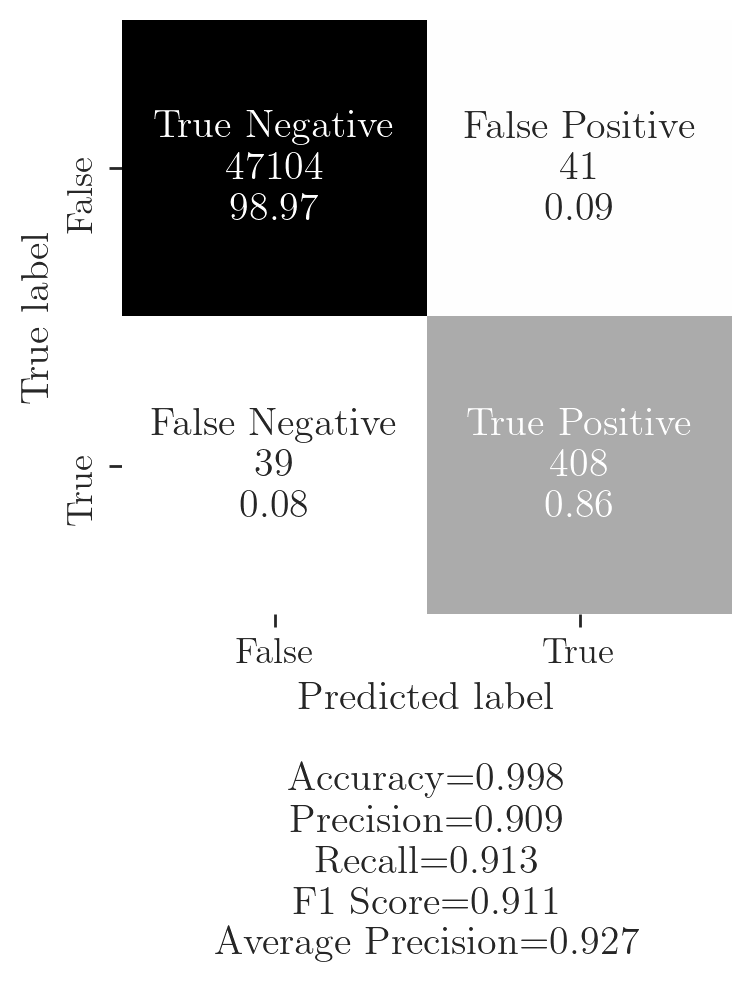

In [21]:
sns.set(context="paper", style="ticks", palette="colorblind", font='serif', font_scale=1.5, color_codes=True, rc=pu.figure_setup())


fig_size = pu.get_fig_size(10, 10)

fig, ax = plt.subplots(figsize=fig_size)

ax.yaxis.grid(True)
ax.xaxis.grid(False)

labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['False', 'True']
make_confusion_matrix(cf_matrix, fig, ax,
                      group_names=labels,
                      categories=categories, cbar=False, cmap="binary", average_precision=average_precision)
pu.save_plot(fig, "confusion_matrix")

In [16]:
accuracy = (df_merged["truth"] == predictions).mean()

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
accuracy

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.9983298613605345

In [30]:
df_merged

,assembly_accession,hits,percent_coverage,mean_coverage,sd_coverage,percent_padded_coverage,mean_padded_coverage,sd_padded_coverage,percent_binned_coverage,mean_binned_coverage,...,pplacer_taxonomy,classification_method,note,"other_related_references(genome_id,species_name,radius,ANI,AF)",aa_percent,translation_table,red_value,warnings,closest_assembly_accession,truth
0,GCF_000421645.1,4255809,0.995714,201.831981,53.483335,0.995861,184.377103,48.871567,0.9962,425.5804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCF_000421645.1,True
1,GCF_001757355.1,11345,0.004239,0.492506,7.861452,0.004248,0.449914,7.186107,0.0047,1.1345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCF_000421645.1,False
2,GCF_000510685.1,266,0.000093,0.007391,0.929994,0.000109,0.007820,0.956418,0.0002,0.0266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCF_000421645.1,False
3,GCF_000153465.1,14244,0.004559,0.730458,20.172310,0.004369,0.658342,18.344300,0.0068,1.4244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCF_000421645.1,False
4,GCF_000497755.1,11955,0.005128,0.633937,9.130293,0.005149,0.576884,8.321191,0.0055,1.1955,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCF_000421645.1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55679,GCF_000369525.1,1,0.000021,0.000021,0.004537,0.000043,0.000043,0.006548,0.0001,0.0001,...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,taxonomic classification defined by topology a...,topological placement and ANI have congruent s...,"GCA_004345325.1, s__Acinetobacter calcoaceticu...",99.13,11.0,NaN,NaN,GCF_000829675.1,False
55680,GCF_000368565.1,1,0.000022,0.000022,0.004665,0.000044,0.000044,0.006597,0.0001,0.0001,...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,taxonomic classification defined by topology a...,topological placement and ANI have congruent s...,"GCA_004345325.1, s__Acinetobacter calcoaceticu...",99.13,11.0,NaN,NaN,GCF_000829675.1,False
55681,GCF_002165305.2,1,0.000025,0.000025,0.004995,0.000050,0.000050,0.007100,0.0001,0.0001,...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,taxonomic classification defined by topology a...,topological placement and ANI have congruent s...,"GCA_004345325.1, s__Acinetobacter calcoaceticu...",99.13,11.0,NaN,NaN,GCF_000829675.1,False
55682,GCF_001647535.1,1,0.000026,0.000026,0.005141,0.000064,0.000064,0.007980,0.0001,0.0001,...,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,taxonomic classification defined by topology a...,topological placement and ANI have congruent s...,"GCA_004345325.1, s__Acinetobacter calcoaceticu...",99.13,11.0,NaN,NaN,GCF_000829675.1,False


In [18]:
df_merged["truth"].sum()

520

In [19]:
predictions.sum()

515

In [20]:
predictions.sum()

515

In [21]:
df_merged.loc[:, "truth"] == False

0        False
1         True
2         True
3         True
4         True
         ...  
55679     True
55680     True
55681     True
55682     True
55683     True
Name: truth, Length: 55684, dtype: bool

In [22]:
df_merged.columns

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['assembly_accession', 'hits', 'percent_coverage', 'mean_coverage',
       'sd_coverage', 'percent_padded_coverage', 'mean_padded_coverage',
       'sd_padded_coverage', 'percent_binned_coverage', 'mean_binned_coverage',
       ...
       'pplacer_taxonomy', 'classification_method', 'note',
       'other_related_references(genome_id,species_name,radius,ANI,AF)',
       'aa_percent', 'translation_table', 'red_value', 'warnings',
       'closest_assembly_accession', 'truth'],
      dtype='object', length=350)

In [23]:
df_merged.groupby("dataset")["truth"].sum()

dataset
DRR106196     1
DRR124440     1
ERR028185     1
ERR1022315    2
ERR1448080    1
             ..
SRR9062704    1
SRR9062705    1
SRR9587899    2
SRR960600     2
SRR965016     2
Name: truth, Length: 449, dtype: int64

In [24]:
df_merged.query("assembly_accession == 'GCF_000621165.1'")
# "GCF_000424785.1"

,assembly_accession,hits,percent_coverage,mean_coverage,sd_coverage,percent_padded_coverage,mean_padded_coverage,sd_padded_coverage,percent_binned_coverage,mean_binned_coverage,...,pplacer_taxonomy,classification_method,note,"other_related_references(genome_id,species_name,radius,ANI,AF)",aa_percent,translation_table,red_value,warnings,closest_assembly_accession,truth
1614,GCF_000621165.1,3,0.000018,0.000052,0.012280,0.000038,0.000109,0.017902,0.0001,0.0003,...,d__Bacteria;p__Actinobacteriota;c__Actinomycet...,taxonomic classification defined by topology a...,topological placement and ANI have congruent s...,"GCF_000177195.2, s__Streptomyces sp000177195, ...",94.01,11.0,NaN,NaN,GCF_000720535.1,False
2743,GCF_000621165.1,35,0.000038,0.000591,0.107872,0.000077,0.001272,0.160760,0.0002,0.0035,...,d__Bacteria;p__Actinobacteriota;c__Actinomycet...,taxonomic classification defined by topology a...,topological placement and ANI have congruent s...,"GCF_000177195.2, s__Streptomyces sp000177195, ...",94.01,11.0,NaN,NaN,GCF_000720535.1,False
6357,GCF_000621165.1,796,0.017275,0.019756,0.156323,0.023671,0.028925,0.197384,0.0535,0.0796,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCF_000745975.1,False
6711,GCF_000621165.1,75,0.000039,0.001378,0.252092,0.000078,0.002725,0.352468,0.0002,0.0075,...,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,taxonomic classification defined by topology a...,topological placement and ANI have congruent s...,"GCF_001625325.1, s__Caenibius sp001625325, 95....",98.45,11.0,NaN,NaN,GCF_003860345.1,False
10530,GCF_000621165.1,3,0.000036,0.000054,0.009455,0.000073,0.000109,0.013452,0.0002,0.0003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCF_000966355.1,False
10866,GCF_000621165.1,127,0.000043,0.002350,0.424982,0.000083,0.004615,0.593062,0.0002,0.0127,...,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,taxonomic classification defined by topology a...,topological placement and ANI have congruent s...,"GCF_001625325.1, s__Caenibius sp001625325, 95....",98.45,11.0,NaN,NaN,GCF_003860345.1,False
17289,GCF_000621165.1,617,0.013464,0.015498,0.139384,0.018340,0.022421,0.174162,0.0421,0.0617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCF_000701425.1,False
17522,GCF_000621165.1,627,0.013923,0.015731,0.138354,0.019053,0.022784,0.172938,0.0444,0.0627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCF_000701405.1,False
20250,GCF_000621165.1,41,0.000120,0.001083,0.144194,0.000182,0.001490,0.169331,0.0003,0.0041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCF_003350295.1,False
22976,GCF_000621165.1,1113,0.024146,0.027888,0.186521,0.032647,0.040444,0.234450,0.0724,0.1113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCF_000701505.1,False


In [25]:
df_merged.loc[predictions == (df_merged.loc[:, "truth"] == False).values]

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,assembly_accession,hits,percent_coverage,mean_coverage,sd_coverage,percent_padded_coverage,mean_padded_coverage,sd_padded_coverage,percent_binned_coverage,mean_binned_coverage,...,pplacer_taxonomy,classification_method,note,"other_related_references(genome_id,species_name,radius,ANI,AF)",aa_percent,translation_table,red_value,warnings,closest_assembly_accession,truth
6346,GCF_000688515.1,18355,0.411439,0.580088,0.828387,0.554570,0.947647,1.113514,0.7456,1.8355,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCF_000745975.1,False
9452,GCF_000425825.1,3437,0.298288,0.358547,0.604387,0.275457,0.325732,0.575230,0.2882,0.3437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCF_000425485.1,False
9655,GCF_001403875.1,23654,0.040110,1.031235,9.017787,0.042818,0.798538,6.939910,0.0724,2.3654,...,d__Bacteria;p__Firmicutes;c__Bacilli;o__Paenib...,taxonomic classification defined by topology a...,NaN,"GCF_000381905.1, s__Paenibacillus_Q fonticola,...",93.79,11.0,0.984892,Genome not assigned to closest species as it f...,GCF_001403875.1,True
9823,GCF_002950215.1,156235,0.561607,3.103127,4.127414,0.677963,6.327436,7.336087,0.7691,15.6235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCF_000966355.1,False
11686,GCF_000733865.1,3028,0.339741,0.523760,0.866522,0.408115,0.712261,1.055844,0.2345,0.3028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCF_000701665.1,False
11850,GCF_000620845.1,11207,0.567862,0.887253,1.020444,0.529634,0.796487,0.960862,0.6532,1.1207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCF_000702625.1,False
11851,GCF_000620805.1,8140,0.350806,0.555220,0.914874,0.329601,0.501515,0.855122,0.4433,0.8140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCF_000702625.1,False
12588,GCF_900101345.1,366571,0.064739,6.760804,47.900965,0.094375,11.216767,72.009838,0.1940,36.6571,...,d__Bacteria;p__Desulfobacterota;c__Desulfobact...,taxonomic classification defined by topology a...,NaN,NaN,92.66,11.0,0.980065,Genome not assigned to closest species as it f...,GCF_900101345.1,True
12889,GCF_900101345.1,359380,0.061782,6.648154,47.527746,0.089018,10.996728,71.432259,0.1832,35.9380,...,d__Bacteria;p__Desulfobacterota;c__Desulfobact...,taxonomic classification defined by topology a...,NaN,NaN,92.66,11.0,0.980065,Genome not assigned to closest species as it f...,GCF_900101345.1,True
13329,GCF_000310205.1,47180,0.718784,1.474543,1.400461,0.833035,2.244359,1.814608,0.9568,4.7180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GCF_000688295.1,False


In [26]:
df_merged.loc[predictions == (df_merged.loc[:, "truth"] == False).values, "dataset"]

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


6346      SRR3313997
9452      SRR3721047
9655     SRR10541910
9823      SRR1578063
11686     SRR3493381
11850     SRR3723469
11851     SRR3723469
12588     ERR3208638
12889     ERR3208638
13329     SRR3452921
14822     SRR3721286
15481    SRR11608288
15552    SRR11608288
16392     SRR8552605
16508     SRR8552605
16801    SRR11650030
16843    SRR11650030
17023    SRR10673227
17159    SRR10673227
17282     SRR3314042
17504     SRR3314039
17753    SRR12416468
17901    SRR12416468
18053    SRR10872703
18109    SRR10872703
21126     SRR8392519
23951     SRR3948003
25987     SRR6977389
26009     SRR6977389
27557     SRR3501420
27900     SRR4235378
27903     SRR4235378
28039     SRR3493861
28189     SRR5872858
31346     SRR4159442
31443     SRR7081601
31565     SRR4140225
34127      SRR445760
35220     SRR5029787
35243     SRR5029787
35539     SRR4233911
35716     SRR3945093
35747     SRR3945093
36082     SRR1945089
36415     SRR6654096
37244     SRR4407852
39087     SRR9010588
39605     SRR